In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

In [3]:
import os
import requests
import json
import time
from datetime import datetime

In [5]:
# CONFIGURATION
CLIENT_ID = os.getenv("STRAVA_CLIENT_ID")
CLIENT_SECRET = os.getenv("STRAVA_CLIENT_SECRET")
REDIRECT_URI = 'http://localhost/exchange_token'  # Same as registered
SCOPE = 'read,activity:read_all'

# STEP 1: GET AUTHORIZATION URL
def get_authorization_url():
    url = (
        f"https://www.strava.com/oauth/authorize"
        f"?client_id={CLIENT_ID}"
        f"&response_type=code"
        f"&redirect_uri={REDIRECT_URI}"
        f"&approval_prompt=force"
        f"&scope={SCOPE}"
    )
    return url

# STEP 2: EXCHANGE CODE FOR ACCESS TOKEN
def exchange_code_for_token(auth_code):
    response = requests.post(
        'https://www.strava.com/oauth/token',
        data={
            'client_id': CLIENT_ID,
            'client_secret': CLIENT_SECRET,
            'code': auth_code,
            'grant_type': 'authorization_code'
        }
    )
    token_data = response.json()
    with open('strava_token.json', 'w') as f:
        json.dump(token_data, f)
    return token_data

# STEP 3: REFRESH ACCESS TOKEN IF EXPIRED
def refresh_access_token():
    with open('strava_token.json') as f:
        tokens = json.load(f)

    response = requests.post(
        'https://www.strava.com/oauth/token',
        data={
            'client_id': CLIENT_ID,
            'client_secret': CLIENT_SECRET,
            'grant_type': 'refresh_token',
            'refresh_token': tokens['refresh_token']
        }
    )

    new_tokens = response.json()
    with open('strava_token.json', 'w') as f:
        json.dump(new_tokens, f)
    return new_tokens['access_token']

# STEP 4: GET ATHLETE ACTIVITIES
def get_activities(after=None, before=None, per_page=30):
    with open('strava_token.json') as f:
        tokens = json.load(f)

    access_token = tokens.get('access_token')

    params = {
        'per_page': per_page,
    }
    if after:
        params['after'] = int(after)
    if before:
        params['before'] = int(before)

    response = requests.get(
        'https://www.strava.com/api/v3/athlete/activities',
        headers={'Authorization': f'Bearer {access_token}'},
        params=params
    )

    if response.status_code == 401:
        print("Access token expired, refreshing...")
        access_token = refresh_access_token()
        return get_activities(after, before, per_page)

    return response.json()


In [40]:
# MAIN WORKFLOW

# 1. First-time only: print URL and paste back code
print("Visit this URL and get the code:")
print(get_authorization_url())
# After visiting and authorizing, paste the ?code=XXXXX from the redirect URL
auth_code = input("Paste the code here: ")
exchange_code_for_token(auth_code)

# 2. Fetch recent activities
activities = get_activities()

Visit this URL and get the code:
https://www.strava.com/oauth/authorize?client_id=77358&response_type=code&redirect_uri=http://localhost/exchange_token&approval_prompt=force&scope=read,activity:read_all


In [6]:
activities = get_activities(after=datetime(2025, 6, 1).timestamp())

In [7]:
datetime(2025, 6, 1).date().strftime("%Y-%m-%d")

'2025-06-01'

In [8]:
len(activities)

30

In [9]:
df = pd.DataFrame(activities)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 55 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   resource_state                 30 non-null     int64  
 1   athlete                        30 non-null     object 
 2   name                           30 non-null     object 
 3   distance                       30 non-null     float64
 4   moving_time                    30 non-null     int64  
 5   elapsed_time                   30 non-null     int64  
 6   total_elevation_gain           30 non-null     float64
 7   type                           30 non-null     object 
 8   sport_type                     30 non-null     object 
 9   workout_type                   18 non-null     float64
 10  id                             30 non-null     int64  
 11  start_date                     30 non-null     object 
 12  start_date_local               30 non-null     objec

In [10]:
df["type"].value_counts().to_dict()

{'Run': 18, 'Yoga': 11, 'Ride': 1}

In [11]:
map_df = pd.DataFrame(df[df["type"].isin(["Ride", "Run"])]["map"].values.tolist())
map_df["id"] = map_df["id"].str.replace("a", "").astype(int)

In [12]:
map_df

,id,summary_polyline,resource_state
0,14666624880,o|{wF`jqbM_B@{KkE{RuScQ{@kM}IiAoByAoFkBoBiI{@w...,2
1,14677298402,_}{wFfbqbMb@b@DN@Zc@|B[t@Ib@KTm@NoAf@MR_@x@GFi...,2
2,14689950841,eu{wF~|pbMf@q@H_Ah@mAR}@VkCXk@f@_CrBiG`@e@ReBl...,2
3,14699177135,k}{wF~iqbMU@S\e@LWVw@d@_@^OVGXE^Pb@GFSFFR@`@L`...,2
4,14699519721,oqpwFd~nbMNNb@HdCZT@RCPKNSHWAYIa@Q_@MKaEa@SBOJ...,2
5,14723892958,o{{wF`bqbMDp@Mz@GnAQfAg@r@kBz@m@d@aAhBOBYg@IC}...,2
6,14736911506,giowFhzubM_@^A`@Np@AhCFZLHPR?TIVYj@Wn@MRm@n@_@...,2
7,14749429708,ot{wFldqbMXGx@iCDgAl@qAh@m@FSVe@NcAJg@`@e@PYTi...,2
8,14754483462,}d|wFjtqbMBh@Ih@@JDHHDdA`@d@Dn@l@|@h@j@b@\NV?v...,2
9,14759682495,}x{wFrbqbMFM@a@Fc@d@i@H[JgA?YEa@?Wb@i@P]^kADa@...,2


In [13]:
cols = ["id", "sport_type", "name", "visibility", "start_date_local",
        "distance", "moving_time", "elapsed_time", "average_speed", "average_cadence", "total_elevation_gain", "elev_high", "elev_low",
        "average_heartrate", "max_heartrate", "average_watts", "max_watts", "weighted_average_watts", "kilojoules"]

In [14]:
df[df["type"]=="Run"].tail()[cols]

,id,sport_type,name,visibility,start_date_local,distance,moving_time,elapsed_time,average_speed,average_cadence,total_elevation_gain,elev_high,elev_low,average_heartrate,max_heartrate,average_watts,max_watts,weighted_average_watts,kilojoules
22,14822037733,Run,Evening Run,followers_only,2025-06-16T18:38:49Z,5009.2,1808,1808,2.771,86.2,22.0,25.0,5.0,137.7,164.0,158.8,332.0,160.0,287.1
23,14827241000,Run,Morning Run,everyone,2025-06-17T07:13:27Z,15318.6,5288,5540,2.897,85.9,119.0,73.0,32.0,147.5,169.0,152.7,307.0,154.0,807.5
25,14837849186,Run,"6x (800@T, 400rec)",everyone,2025-06-18T06:21:42Z,13010.0,4045,4567,3.216,88.5,65.0,56.0,38.0,161.4,185.0,183.9,268.0,180.0,743.8
27,14849483826,Run,Morning Run,everyone,2025-06-19T08:13:42Z,8144.0,2846,2923,2.862,86.2,85.0,32.0,8.0,152.3,173.0,164.0,253.0,163.0,466.8
29,14859914208,Run,2x 10min@T w/2min rec,everyone,2025-06-20T06:16:12Z,13689.5,4334,5390,3.159,88.4,104.0,47.0,17.0,162.9,184.0,180.7,259.0,176.0,783.0


In [15]:
run_df = pd.merge(df[df["type"]=="Run"][cols], map_df, on="id", how="left")
run_df

,id,sport_type,name,visibility,start_date_local,distance,moving_time,elapsed_time,average_speed,average_cadence,total_elevation_gain,elev_high,elev_low,average_heartrate,max_heartrate,average_watts,max_watts,weighted_average_watts,kilojoules,summary_polyline,resource_state
0,14677298402,Run,Afternoon Run,followers_only,2025-06-02T17:59:48Z,8725.5,2921,3134,2.987,86.0,39.0,38.0,12.0,158.3,188.0,163.8,338.0,163.0,478.3,_}{wFfbqbMb@b@DN@Zc@|B[t@Ib@KTm@NoAf@MR_@x@GFi...,2
1,14689950841,Run,Evening Run,followers_only,2025-06-03T20:04:37Z,15456.7,5128,5654,3.014,87.3,119.0,44.0,-1.0,155.7,188.0,157.5,333.0,155.0,807.5,eu{wF~|pbMf@q@H_Ah@mAR}@VkCXk@f@_CrBiG`@e@ReBl...,2
2,14699177135,Run,Evening Run,followers_only,2025-06-04T18:12:47Z,7706.9,2578,2686,2.989,87.2,8.0,71.0,49.0,161.6,179.0,157.5,264.0,159.0,405.9,k}{wF~iqbMU@S\e@LWVw@d@_@^OVGXE^Pb@GFSFFR@`@L`...,2
3,14699519721,Run,Evening Run,everyone,2025-06-04T19:17:46Z,4900.1,1511,1525,3.243,88.1,2.0,11.0,4.0,181.9,193.0,183.2,270.0,187.0,276.8,oqpwFd~nbMNNb@HdCZT@RCPKNSHWAYIa@Q_@MKaEa@SBOJ...,2
4,14723892958,Run,Morning Run,everyone,2025-06-07T07:43:43Z,19009.8,6460,6613,2.943,86.1,55.0,29.0,7.0,154.7,187.0,167.4,267.0,170.0,1081.2,o{{wF`bqbMDp@Mz@GnAQfAg@r@kBz@m@d@aAhBOBYg@IC}...,2
5,14736911506,Run,Lunch Run,only_me,2025-06-08T12:30:18Z,8916.6,3018,3153,2.954,87.0,29.0,27.0,5.0,147.4,173.0,163.4,250.0,164.0,493.2,giowFhzubM_@^A`@Np@AhCFZLHPR?TIVYj@Wn@MRm@n@_@...,2
6,14749429708,Run,Afternoon Run,followers_only,2025-06-09T17:59:17Z,9260.6,3246,3246,2.853,85.9,62.0,52.0,29.0,142.0,160.0,158.6,212.0,159.0,514.8,ot{wFldqbMXGx@iCDgAl@qAh@m@FSVe@NcAJg@`@e@PYTi...,2
7,14754483462,Run,Morning Run,followers_only,2025-06-10T07:47:40Z,9168.2,3271,3607,2.803,87.6,22.0,15.0,2.0,145.6,163.0,154.8,209.0,153.0,506.4,}d|wFjtqbMBh@Ih@@JDHHDdA`@d@Dn@l@|@h@j@b@\NV?v...,2
8,14759682495,Run,Afternoon Run,only_me,2025-06-10T17:11:09Z,5771.4,1988,2133,2.903,86.6,42.0,42.0,23.0,140.8,161.0,160.2,219.0,156.0,318.5,}x{wFrbqbMFM@a@Fc@d@i@H[JgA?YEa@?Wb@i@P]^kADa@...,2
9,14764805826,Run,Morning Run,everyone,2025-06-11T06:17:22Z,11864.6,4170,5221,2.845,88.5,48.0,52.0,27.0,162.9,185.0,172.3,288.0,170.0,718.4,sy{wF`aqbMXk@JYPW\kA^{@V{@Fq@TcAFI~@{@Rg@V_@Ps...,2


In [16]:
# Convert pace from decimal to min:seconds format
def decimal_to_time(decimal_time):
    minutes = int(decimal_time)
    seconds = int((decimal_time - minutes) * 60)
    return f"{minutes}:{seconds:02d}"

def time_to_decimal(time_str):
    minutes, seconds = map(int, time_str.split(':'))
    return minutes + seconds / 60

In [17]:
run_df["start_date_local"] = pd.to_datetime(run_df["start_date_local"])
run_df['distance_mile'] = run_df['distance'] / 1609.34
run_df['moving_time_minute'] = run_df['moving_time'] / 60
run_df['pace'] = run_df['moving_time_minute'] / run_df['distance_mile']
run_df["total_elevation_gain_ft"] = run_df["total_elevation_gain"] * 3.28084
run_df['pace'] = run_df['pace'].apply(decimal_to_time)
run_df["week"] = pd.to_datetime(run_df["start_date_local"]).dt.isocalendar().week
run_df["weekly_milages_cumsum"] = run_df.groupby("week")["distance_mile"].cumsum().round(2)
run_df[['name', 'distance_mile', 'moving_time_minute', 'pace', 'total_elevation_gain_ft']].head()

,name,distance_mile,moving_time_minute,pace,total_elevation_gain_ft
0,Afternoon Run,5.421788,48.683333,8:58,127.95276
1,Evening Run,9.604372,85.466667,8:53,390.41996
2,Evening Run,4.788858,42.966667,8:58,26.24672
3,Evening Run,3.044789,25.183333,8:16,6.56168
4,Morning Run,11.812171,107.666667,9:06,180.44620


In [18]:
run_df

,id,sport_type,name,visibility,start_date_local,distance,moving_time,elapsed_time,average_speed,average_cadence,total_elevation_gain,elev_high,elev_low,average_heartrate,max_heartrate,average_watts,max_watts,weighted_average_watts,kilojoules,summary_polyline,resource_state,distance_mile,moving_time_minute,pace,total_elevation_gain_ft,week,weekly_milages_cumsum
0,14677298402,Run,Afternoon Run,followers_only,2025-06-02 17:59:48+00:00,8725.5,2921,3134,2.987,86.0,39.0,38.0,12.0,158.3,188.0,163.8,338.0,163.0,478.3,_}{wFfbqbMb@b@DN@Zc@|B[t@Ib@KTm@NoAf@MR_@x@GFi...,2,5.421788,48.683333,8:58,127.95276,23,5.42
1,14689950841,Run,Evening Run,followers_only,2025-06-03 20:04:37+00:00,15456.7,5128,5654,3.014,87.3,119.0,44.0,-1.0,155.7,188.0,157.5,333.0,155.0,807.5,eu{wF~|pbMf@q@H_Ah@mAR}@VkCXk@f@_CrBiG`@e@ReBl...,2,9.604372,85.466667,8:53,390.41996,23,15.03
2,14699177135,Run,Evening Run,followers_only,2025-06-04 18:12:47+00:00,7706.9,2578,2686,2.989,87.2,8.0,71.0,49.0,161.6,179.0,157.5,264.0,159.0,405.9,k}{wF~iqbMU@S\e@LWVw@d@_@^OVGXE^Pb@GFSFFR@`@L`...,2,4.788858,42.966667,8:58,26.24672,23,19.82
3,14699519721,Run,Evening Run,everyone,2025-06-04 19:17:46+00:00,4900.1,1511,1525,3.243,88.1,2.0,11.0,4.0,181.9,193.0,183.2,270.0,187.0,276.8,oqpwFd~nbMNNb@HdCZT@RCPKNSHWAYIa@Q_@MKaEa@SBOJ...,2,3.044789,25.183333,8:16,6.56168,23,22.86
4,14723892958,Run,Morning Run,everyone,2025-06-07 07:43:43+00:00,19009.8,6460,6613,2.943,86.1,55.0,29.0,7.0,154.7,187.0,167.4,267.0,170.0,1081.2,o{{wF`bqbMDp@Mz@GnAQfAg@r@kBz@m@d@aAhBOBYg@IC}...,2,11.812171,107.666667,9:06,180.44620,23,34.67
5,14736911506,Run,Lunch Run,only_me,2025-06-08 12:30:18+00:00,8916.6,3018,3153,2.954,87.0,29.0,27.0,5.0,147.4,173.0,163.4,250.0,164.0,493.2,giowFhzubM_@^A`@Np@AhCFZLHPR?TIVYj@Wn@MRm@n@_@...,2,5.540532,50.300000,9:04,95.14436,23,40.21
6,14749429708,Run,Afternoon Run,followers_only,2025-06-09 17:59:17+00:00,9260.6,3246,3246,2.853,85.9,62.0,52.0,29.0,142.0,160.0,158.6,212.0,159.0,514.8,ot{wFldqbMXGx@iCDgAl@qAh@m@FSVe@NcAJg@`@e@PYTi...,2,5.754284,54.100000,9:24,203.41208,24,5.75
7,14754483462,Run,Morning Run,followers_only,2025-06-10 07:47:40+00:00,9168.2,3271,3607,2.803,87.6,22.0,15.0,2.0,145.6,163.0,154.8,209.0,153.0,506.4,}d|wFjtqbMBh@Ih@@JDHHDdA`@d@Dn@l@|@h@j@b@\NV?v...,2,5.696870,54.516667,9:34,72.17848,24,11.45
8,14759682495,Run,Afternoon Run,only_me,2025-06-10 17:11:09+00:00,5771.4,1988,2133,2.903,86.6,42.0,42.0,23.0,140.8,161.0,160.2,219.0,156.0,318.5,}x{wFrbqbMFM@a@Fc@d@i@H[JgA?YEa@?Wb@i@P]^kADa@...,2,3.586191,33.133333,9:14,137.79528,24,15.04
9,14764805826,Run,Morning Run,everyone,2025-06-11 06:17:22+00:00,11864.6,4170,5221,2.845,88.5,48.0,52.0,27.0,162.9,185.0,172.3,288.0,170.0,718.4,sy{wF`aqbMXk@JYPW\kA^{@V{@Fq@TcAFI~@{@Rg@V_@Ps...,2,7.372339,69.500000,9:25,157.48032,24,22.41


In [20]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
file_path = os.path.join("data", f"strava_run_data_{timestamp}.csv")

In [21]:
run_df.to_csv(file_path, index=False)

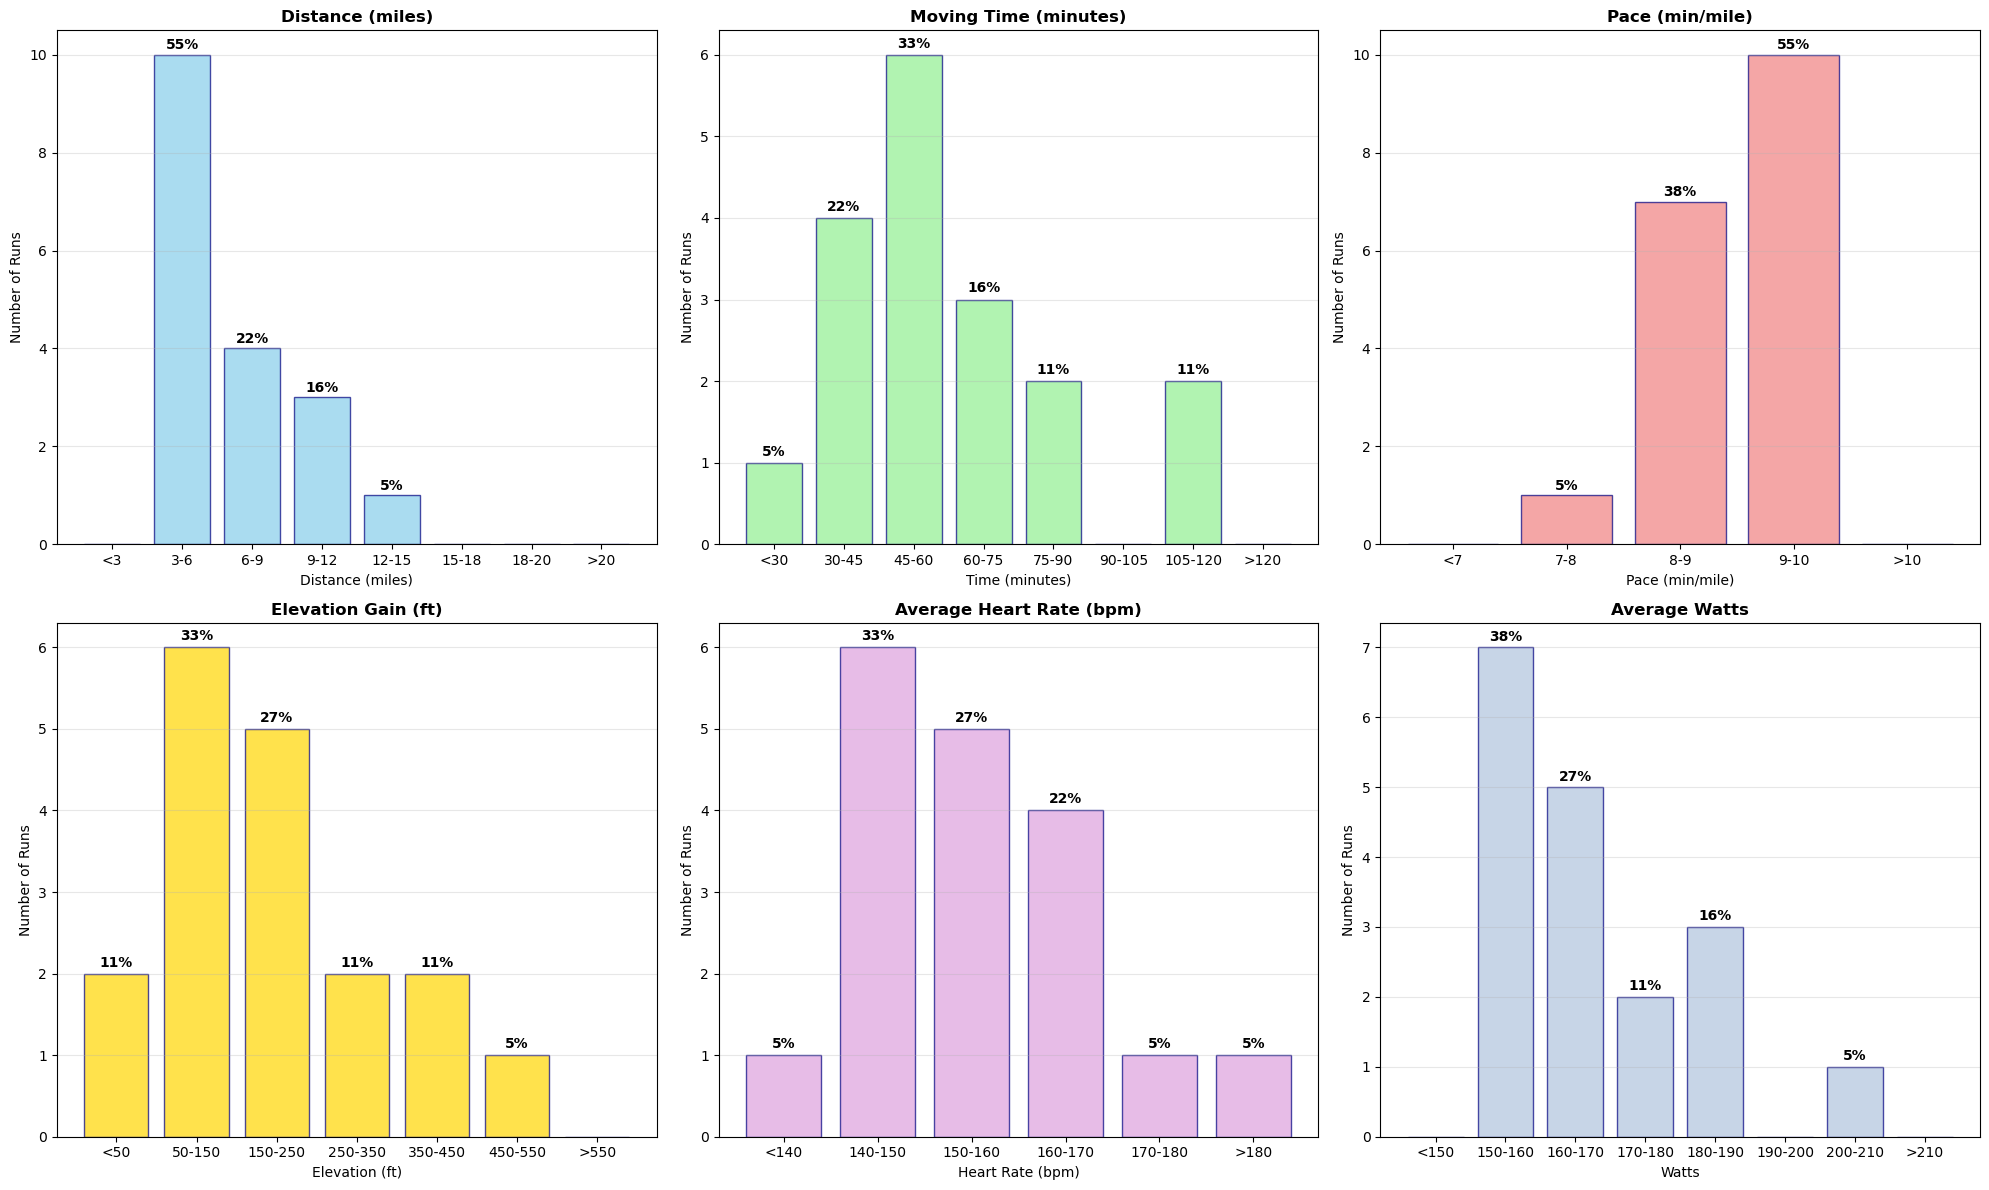

In [143]:
import matplotlib.pyplot as plt

# Define the variables and their bin configurations
variables_config = {
    'distance_mile': {
        'bins': [0, 3, 6, 9, 12, 15, 18, 20, float('inf')],
        'labels': ['<3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-20', '>20'],
        'title': 'Distance (miles)',
        'xlabel': 'Distance (miles)'
    },
    'moving_time_minute': {
        'bins': [0, 30, 45, 60, 75, 90, 105, 120, float('inf')],
        'labels': ['<30', '30-45', '45-60', '60-75', '75-90', '90-105', '105-120', '>120'],
        'title': 'Moving Time (minutes)',
        'xlabel': 'Time (minutes)'
    },
    'pace': {
        'bins': [0, 7, 8, 9, 10, float('inf')],
        'labels': ['<7', '7-8', '8-9', '9-10', '>10'],
        'title': 'Pace (min/mile)',
        'xlabel': 'Pace (min/mile)'
    },
    'total_elevation_gain_ft': {
        'bins': [0, 50, 150, 250, 350, 450, 550, float('inf')],
        'labels': ['<50', '50-150', '150-250', '250-350', '350-450', '450-550', '>550'],
        'title': 'Elevation Gain (ft)',
        'xlabel': 'Elevation (ft)'
    },
    'average_heartrate': {
        'bins': [0, 140, 150, 160, 170, 180, float('inf')],
        'labels': ['<140', '140-150', '150-160', '160-170', '170-180', '>180'],
        'title': 'Average Heart Rate (bpm)',
        'xlabel': 'Heart Rate (bpm)'
    },
    'average_watts': {
        'bins': [0, 150, 160, 170, 180, 190, 200, 210, float('inf')],
        'labels': ['<150', '150-160', '160-170', '170-180', '180-190', '190-200', '200-210', '>210'],
        'title': 'Average Watts',
        'xlabel': 'Watts'
    }
}

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

# Colors for the bars
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum', 'lightsteelblue']

for idx, (var, config) in enumerate(variables_config.items()):
    ax = axes[idx]
    plot_data = run_df[var].apply(time_to_decimal) if var == "pace" else run_df[var]
    hist, bin_edges = np.histogram(plot_data, bins=config['bins'])

    # Create the bar chart
    bars = ax.bar(config['labels'], hist, color=colors[idx], edgecolor='navy', alpha=0.7)
    for bar in bars:
        height = bar.get_height()
        pct = height / len(plot_data) * 100
        if height > 0:  # Only add labels for bars with data
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                    f'{int(pct)}%',
                    ha='center', va='bottom', fontweight='bold', fontsize=10)

    # Customize the chart
    ax.set_xlabel(config['xlabel'], fontsize=10)
    ax.set_ylabel('Number of Runs', fontsize=10)
    ax.set_title(config['title'], fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

    # Rotate x-axis labels for better readability
    plt.setp(ax.get_xticklabels(), ha='center')

plt.tight_layout()
plt.show()

In [151]:
# Calculate summary statistics
summary_stats = {
    'Total Distance (miles)': run_df['distance_mile'].sum(),
    'Total Moving Time (hours)': run_df['moving_time_minute'].sum() / 60,
    'Total Elevation Gain (ft)': run_df['total_elevation_gain_ft'].sum(),
    'Average Pace (min/mile)': decimal_to_time(run_df['pace'].apply(time_to_decimal).mean()),
    'Average Heart Rate (bpm)': run_df['average_heartrate'].mean(),
    'Average Watts': run_df['average_watts'].mean()
}

# Create a formatted display
print("Running Summary Statistics")
print("=" * 50)
print(f"Number of Runs: {len(run_df)}")
# Display totals and averages
for metric, value in summary_stats.items():
    if 'Distance' in metric:
        print(f"{metric}: {value:.1f}")
    elif 'Time' in metric:
        print(f"{metric}: {value:.1f}")
    elif 'Elevation' in metric:
        print(f"{metric}: {value:.0f}")
    elif 'Pace' in metric:
        print(f"{metric}: {value}")
    elif 'Heart Rate' in metric:
        print(f"{metric}: {value:.1f}")
    elif 'Watts' in metric:
        print(f"{metric}: {value:.1f}")

print(f"Average Distance per Run: {run_df['distance_mile'].mean():.1f} miles")
print(f"Average Time per Run: {run_df['moving_time_minute'].mean():.1f} minutes")
print(f"Average Elevation per Run: {run_df['total_elevation_gain_ft'].mean():.0f} ft")


Running Summary Statistics
Number of Runs: 18
Total Distance (miles): 120.5
Total Moving Time (hours): 18.0
Total Elevation Gain (ft): 3501
Average Pace (min/mile): 8:59
Average Heart Rate (bpm): 154.9
Average Watts: 167.3
Average Distance per Run: 6.7 miles
Average Time per Run: 60.0 minutes
Average Elevation per Run: 194 ft
